In [1]:
from import_images import getImages
from import_model import getModel
from make_predictions import makePredictions
import numpy as np

import torch

from cellpose import resnet_torch
from cellpose import transforms
from cellpose import utils
import cv2

import time

from unet_architecture import UNet
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
import torchvision
import numpy as np

import matplotlib.pyplot as plt

In [2]:
images_directory = "C:\\Users\\rz200\\Documents\\development\\distillCellSegTrack\\pipeline\\uploads\\"
images = getImages(images_directory)

directory = "C:\\Users\\rz200\\Documents\\development\\distillCellSegTrack\\datasets\\Fluo-C2DL-Huh7\\01\\models\\CP_20230601_101328"
cellpose_model = getModel(directory)

In [3]:
#get model
directory = "C:\\Users\\rz200\\Documents\\development\\distillCellSegTrack\\datasets\\Fluo-C2DL-Huh7\\01\\models\\CP_20230601_101328"
cpnet = resnet_torch.CPnet(nbase=[2,32,64,128,256],nout=3,sz=3)
cpnet.load_model(directory)

#size at which we rescale the image so that the size of the nucleis match the size the cellpose models needs
rescale = cpnet.diam_mean/cpnet.diam_labels


In [4]:
def get_pre_activations(image,cpnet):
    rescale = cpnet.diam_mean/cpnet.diam_labels
    shape1, shape2 = image.shape[0], image.shape[1]

    x = transforms.resize_image(image, rsz=rescale,no_channels=True)
    x = x.astype(np.float32)
    x = np.expand_dims(x, axis=0)
    x = np.concatenate((x, x), axis=0)
    x = torch.from_numpy(x)
    x = x.unsqueeze(0)

    y, style = cpnet(x)
    y = y.squeeze(0)
    y = y.cpu().detach().numpy()

    return y

In [5]:
training_images = images
training_probability_maps, training_cell_masks = makePredictions(images, cellpose_model)
training_pre_activations = []
for image in training_images:
    training_pre_activations.append(get_pre_activations(image,cpnet))

a
a
a
a
a
a
a
a
a
a
a


In [83]:
print(training_pre_activations[2])

[[[-7.45089306e-03 -9.06166062e-03  3.04475107e-04 ... -8.90545174e-03
   -1.12076234e-02 -1.43942097e-02]
  [ 3.44370343e-02  3.85722779e-02  1.95903610e-02 ...  2.06814520e-02
    2.81572677e-02  3.28557119e-02]
  [ 6.71243342e-03 -9.47278677e-05 -5.78978425e-03 ... -5.73910400e-03
   -1.07792094e-02  2.59275688e-03]
  ...
  [ 5.19329216e-03  4.35438752e-03  2.05655303e-03 ... -1.96130408e-04
   -9.50647704e-03  4.64155572e-03]
  [ 4.28008521e-03 -2.42942180e-02 -1.75563209e-02 ... -2.35101469e-02
   -4.36525047e-02 -2.08746642e-02]
  [-3.37443352e-02  1.44705242e-02  2.18967325e-03 ... -7.65833631e-03
   -4.07460757e-04  8.49146992e-02]]

 [[ 3.80827417e-03  2.38883086e-02  3.35907098e-03 ...  6.01728493e-03
   -1.22920275e-02 -1.36762103e-02]
  [ 1.65419746e-03  3.58102135e-02 -1.17099266e-02 ... -4.04588273e-03
   -3.86235863e-02 -1.83598585e-02]
  [ 9.45457723e-03  3.05860341e-02 -1.04227774e-02 ...  9.75940726e-04
   -1.77196022e-02 -4.23248811e-03]
  ...
  [ 3.27091618e-03  2.4

In [6]:
class ImageDataset(Dataset):
    def __init__(self, image, cellprob, cellmask):
        self.image = image
        self.cellprob = cellprob
        self.cellmask = cellmask

    def __len__(self):
        return len(self.image)

    def __getitem__(self, idx):
        img = self.image[idx]
        cellprob = self.cellprob[idx]
        cellmask = self.cellmask[idx]
        return img, cellprob, cellmask
    
def split_image_set(set):
    splitted = []
    for image in set:
        for i in range(0, 1024, 256):
            for j in range(0, 1024, 256):
                sub_img = image[i:i+256, j:j+256]
                splitted.append(sub_img)
    return splitted

#normalise the training_images
training_images = [(image-np.min(image))/(np.max(image)-np.min(image)) for image in training_images]
#normalise the probability maps
#pm_normalised = [(image-np.min(image))/(np.max(image)-np.min(image)) for image in training_probability_maps]
#binarise the cell masks
cm_binary = [np.where(image > 0, 1.0, 0.0) for image in training_cell_masks]

#pad the images, probability maps and cell masks to 1024x1024
images_pad = [np.pad(img,((0,1024-img.shape[0]),(0,1024-img.shape[1])),mode='constant',constant_values=0) for img in training_images]
pm_norm_pad = [np.pad(img,((0, 0), (0,1024-img.shape[1]),(0,1024-img.shape[2]) ),mode='constant',constant_values=0) for img in training_pre_activations]
cm_bin_pad = [np.pad(img,((0,1024-img.shape[0]),(0,1024-img.shape[1])),mode='constant',constant_values=0) for img in cm_binary]

#split the images, probability maps and cell masks into 256x256 images
images_pad_split = split_image_set(images_pad)
pm_norm_pad_split = []
for image in pm_norm_pad:
    for i in range(0, 1024, 256):
        for j in range(0, 1024, 256):
            sub_img = image[:, i:i+256, j:j+256]
            pm_norm_pad_split.append(sub_img)
cm_bin_pad_split = split_image_set(cm_bin_pad)

#augment with rotations
images_rotated = []
pm_rotated = []
cm_rotated = []
for i in range(len(images_pad_split)):
    for j in range(1,4):
        images_rotated.append(np.rot90(images_pad_split[i],j))
        pm_rotated.append(np.rot90(pm_norm_pad_split[i], j, axes=(1, 2)))
        cm_rotated.append(np.rot90(cm_bin_pad_split[i],j))

#remove the images from cm_bin_pad_split that only have 0s, and remove them from images_pad_split and pm_norm_pad_split
images_pad_split_filtered = [images_rotated[i] for i in range(len(cm_rotated)) if np.sum(cm_rotated[i]) > 0]
pm_norm_pad_split_filtered = [pm_rotated[i] for i in range(len(cm_rotated)) if np.sum(cm_rotated[i]) > 0]
cm_bin_pad_split_filtered = [img for img in cm_rotated if np.sum(img) > 0]

print(len(images_pad_split_filtered), len(pm_norm_pad_split_filtered), len(cm_bin_pad_split_filtered))

images_torch = [torch.from_numpy(np.array(images_pad_split_filtered[i])) for i in range(len(images_pad_split_filtered))]

pm_torch = []
for i in range(len(pm_norm_pad_split_filtered)):
    print(i)
    pm_torch.append(torch.from_numpy(np.array(pm_norm_pad_split_filtered[i])))

cm_torch = [torch.from_numpy(np.array(cm_bin_pad_split_filtered[i])) for i in range(len(cm_bin_pad_split_filtered))]

468 468 468
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
27

In [7]:
unet = UNet(nbClasses=3)
test = unet(torch.rand(1, 1, 256, 256))

print(test.shape)

torch.Size([1, 3, 256, 256])


Training loss:  5.264809806727701 Time:  3.9976308345794678


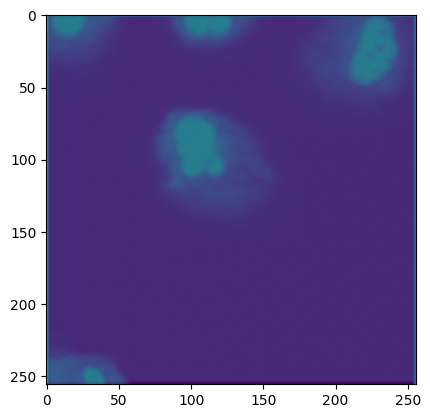

Training loss:  4.921201117527791 Time:  3.7327778339385986


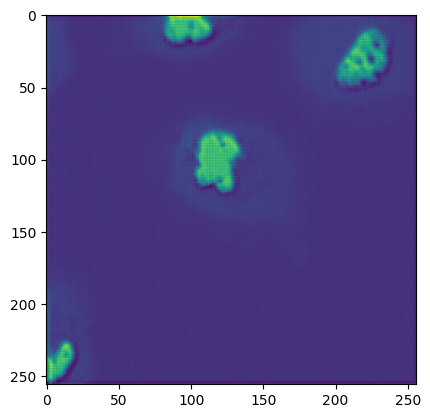

Training loss:  4.958269711233612 Time:  3.5176126956939697


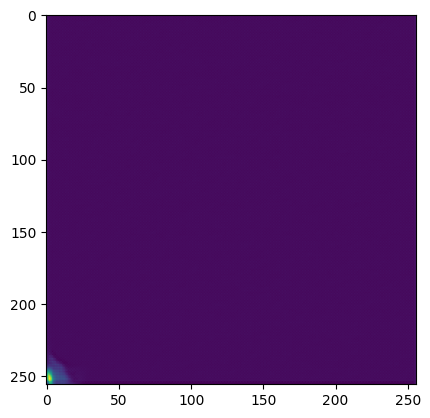

Training loss:  4.913752196690975 Time:  3.5542349815368652


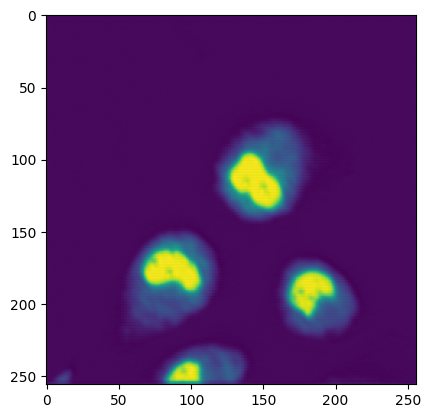

Training loss:  4.98270144370886 Time:  3.605236053466797


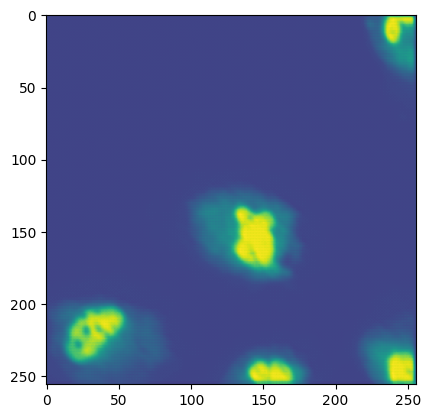

Training loss:  5.043476599021854 Time:  3.4863038063049316


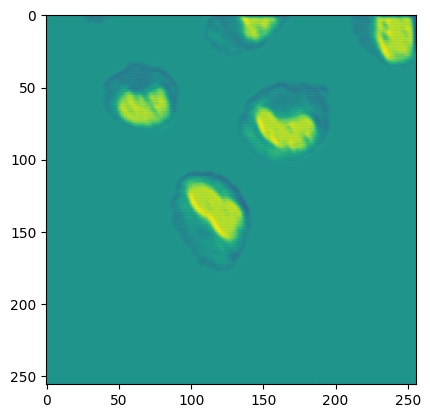

Training loss:  4.89987774588104 Time:  3.725153684616089


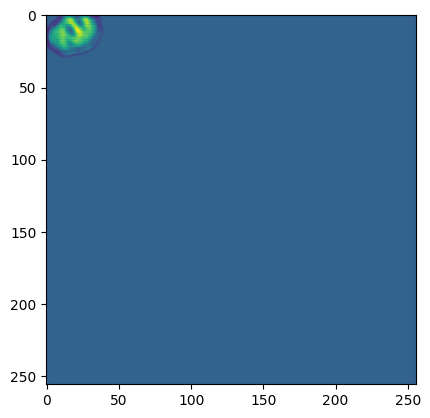

Training loss:  5.011102609145335 Time:  3.5102462768554688


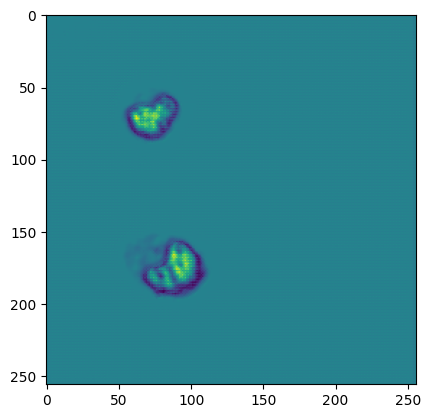

Training loss:  4.971371664450719 Time:  3.68404483795166


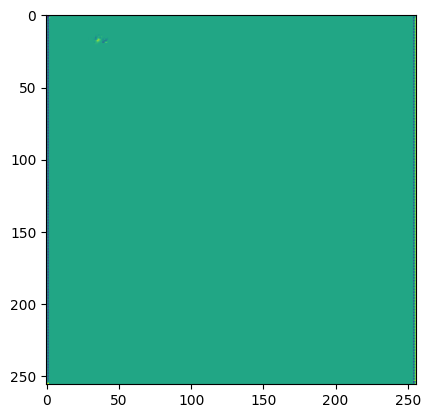

KeyboardInterrupt: 

In [86]:
train_dataset = ImageDataset(images_torch, pm_torch, cm_torch)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)

class KDLoss(torch.nn.Module):
    def __init__(self, alpha=1.0, beta = 0.0, temperature=2):
        super(KDLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta
        self.temperature = temperature

    def forward(self, y_pred_logits, y_pred_mask, y_cp_true, y_cm_true):
        #print(y_pred_logits.shape, y_pred_mask.shape, y_cp_true.shape, y_cm_true.shape)
        
        #y_pred_sig = torch.sigmoid(y_pred_logits)
        #y_pred_bin = torch.where(y_pred_sig > 0.5, 1.0, 0.0)
        #cast y_pred_bin to float
        #y_pred_bin = y_pred_bin.type(torch.FloatTensor)
        kd_loss = F.mse_loss(y_pred_logits, y_cp_true)

        ce_loss = F.binary_cross_entropy_with_logits(y_pred_mask, y_cm_true)

        #binarised = torch.where(F.sigmoid(y_pred_logits) > 0.4, 1.0, 0.0)
        #ce_loss = F.binary_cross_entropy(binarised, y_cp_true)  # compute binary cross-entropy loss
        #loss = F.binary_cross_entropy_with_logits(y_pred_logits, y_cm_true)
        #y_pred_mask = torch.sigmoid(y_pred_logits)  # compute predicted probabilities
        #y_pred_mask = torch.where(y_pred_mask>0.4,1.0,0.0) # binarise
          # compute KL divergence loss
        
        loss = self.alpha * kd_loss + self.beta * ce_loss  # combine losses
        return loss
    
def trainEpoch(unet, train_loader, loss_fn, optimiser, scheduler):
    time_start = time.time()
    
    unet.train()

    train_loss = 0
    for image, cellprob, cellmask in train_loader:
        (image,cellprob,cellmask) = (image.to('cuda:0'),cellprob.to('cuda:0'),cellmask.to('cuda:0')) # sending the data to the device (cpu or GPU)

        image = image.unsqueeze(1)
        pred = unet(image).squeeze(1) #make a prediction
        #print('pred shape', pred.shape)

        detranspose = (1,2,0)
        predicted_masks = []
        for p in pred:
            p = p.cpu().detach().numpy()
            p = np.transpose(p, detranspose)
            p = utils.get_masks_unet(p, cell_threshold=2.0, boundary_threshold=0.5)
            p = utils.fill_holes_and_remove_small_masks(p, min_size=15)
            p = torch.from_numpy(p).to('cuda:0')
            predicted_masks.append(p)
        predicted_masks = torch.stack(predicted_masks).unsqueeze(1)
        
        #cellprob = torch.unsqueeze(cellprob,1)
        cellmask = torch.unsqueeze(cellmask,1)

        #loss = loss_fn(pred, cellprob,10) # calculate the loss of that prediction
        
        #print(torch.unique(pred),torch.unique(predicted_masks),torch.unique(cellprob),torch.unique(cellmask))

        loss = loss_fn(pred, predicted_masks.float(), cellprob, cellmask) # calculate the loss of that prediction
        #loss = loss_fn(pred, cellmask )
        train_loss += loss
    
        optimiser.zero_grad() # zero out the accumulated gradients
        loss.backward() # backpropagate the loss
        optimiser.step() # update model parameters
        scheduler.step()
    train_loss = train_loss.item()/len(train_loader)

    print('Training loss: ', train_loss, 'Time: ', time.time()-time_start)
    plt.imshow(pred[0].cpu().detach().numpy()[0])
    plt.show()

    return unet

unet = UNet(nbClasses=3)
unet = unet.to('cuda:0')
loss_fn = KDLoss()
#loss_fn = IoULoss()
# loss_fn = torchvision.ops.distance_box_iou_loss()
#loss_fn = DiceLoss()
optimiser = torch.optim.SGD(unet.parameters(), lr=0.1, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CyclicLR(optimiser, base_lr=0.001, max_lr=0.1)
num_epochs = 500

for epoch in range(num_epochs):
    unet = trainEpoch(unet, train_loader, loss_fn, optimiser, scheduler)

In [88]:
x = training_images[0]
x = torch.from_numpy(x).to('cuda:0')
x = x.unsqueeze(0)
x = x.unsqueeze(0)

pred = unet(x).cpu().detach().numpy()[0]

print(pred.shape)

plt.imshow(pred[1])
plt.show()

detranspose = (1,2,0)
#p = pred.cpu().detach().numpy()
p = np.transpose(pred, detranspose)
p = utils.get_masks_unet(p, cell_threshold=2.0, boundary_threshold=0.5)
p = utils.fill_holes_and_remove_small_masks(p, min_size=15)
plt.imshow(p)
plt.show()


RuntimeError: CUDA out of memory. Tried to allocate 64.00 MiB (GPU 0; 15.99 GiB total capacity; 15.24 GiB already allocated; 0 bytes free; 15.26 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF